In [1]:
# Download YOLOv3 weights and configuration files
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg -O yolov3.cfg


--2024-11-02 14:24:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  29.9MB/s    in 7.5s    

2024-11-02 14:25:36 (31.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-02 14:25:36--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg [following]
--2024-11-02 14:25:37--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

#***Exercise 1: HOG (Histogram of Oriented Gradients) Object Detection***

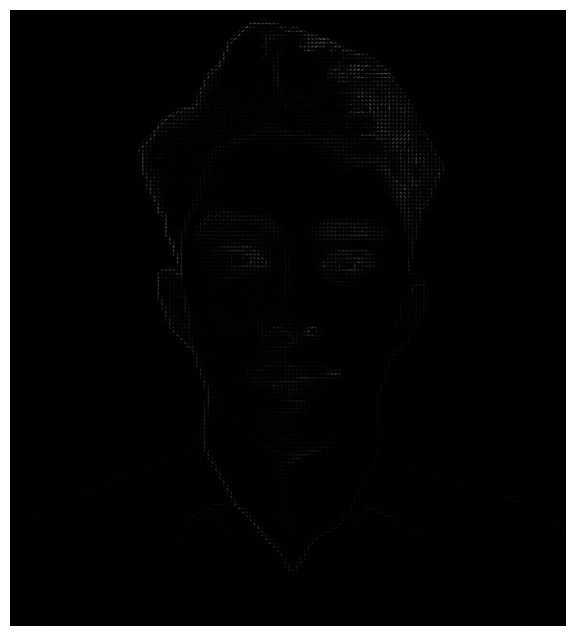

In [2]:
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('original_image1.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply HOG descriptor
# Set channel_axis=None for grayscale images
features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=None)

# Display the HOG image
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(hog_image, cmap='gray')
plt.show()

#***Exercise 2: YOLO (You Only Look Once) Object Detection***

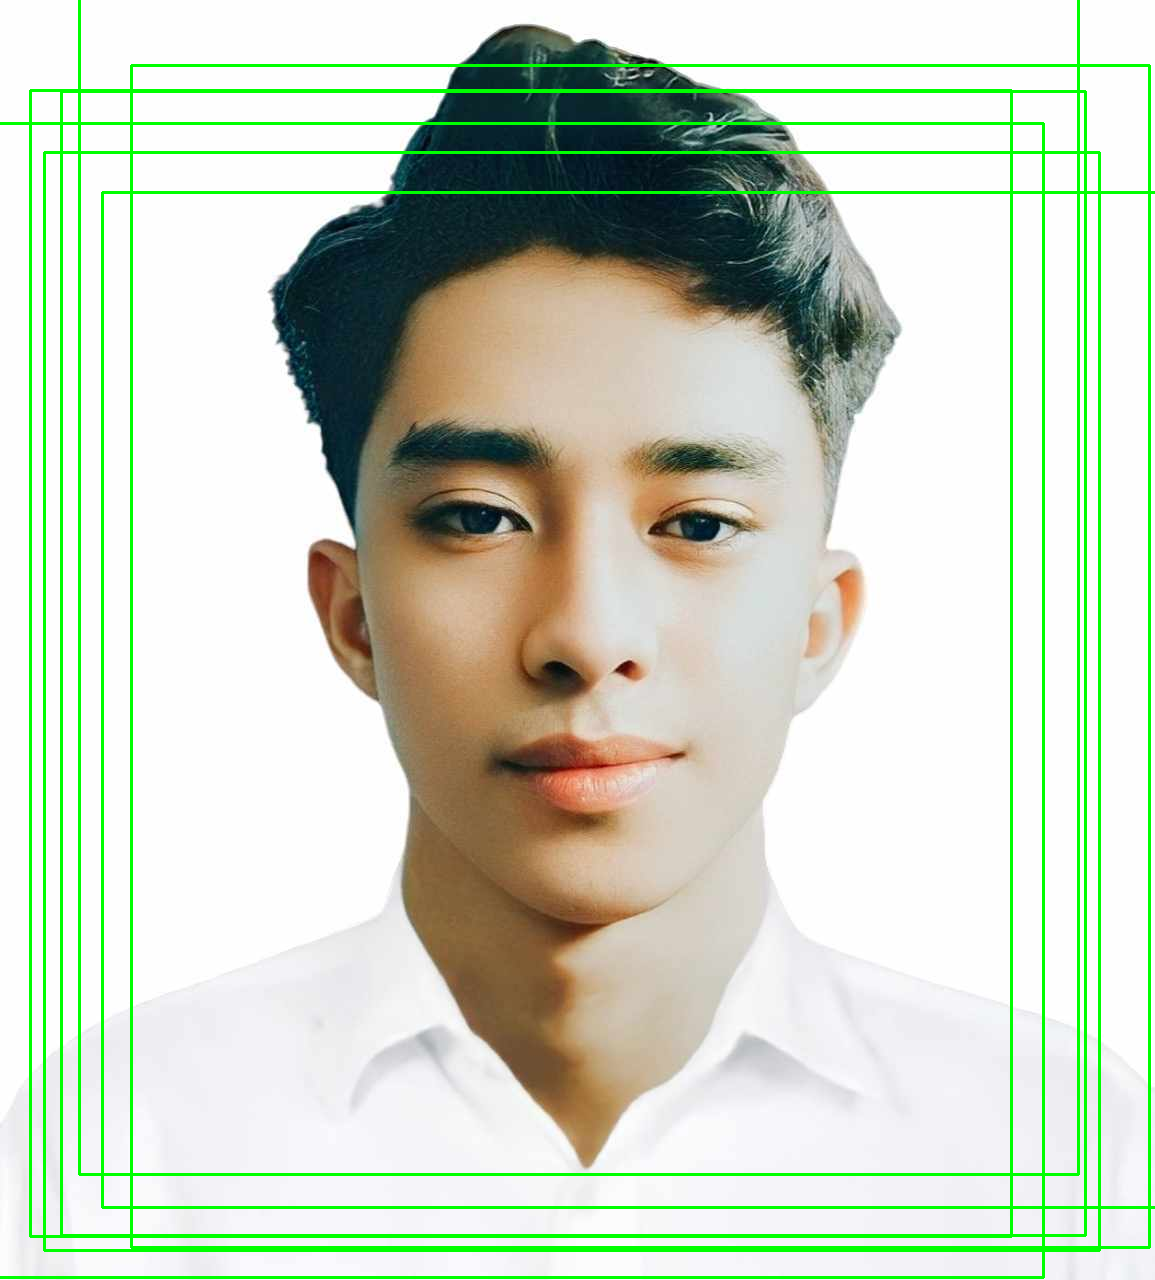

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load YOLO model and configuration
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Load image
image = cv2.imread('original_image1.jpg')
height, width, channels = image.shape

# Prepare the image for YOLO
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Process detections
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Draw bounding box
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image using cv2_imshow
cv2_imshow(image)


#***Exercise 3: SSD (Single Shot MultiBox Detector) with TensorFlow***

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

# URL of the pre-trained SSD MobileNet V2 model
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"

# Load the model from TensorFlow Hub
model = hub.load(model_url)

print("Model loaded successfully from TensorFlow Hub.")


Model loaded successfully from TensorFlow Hub.


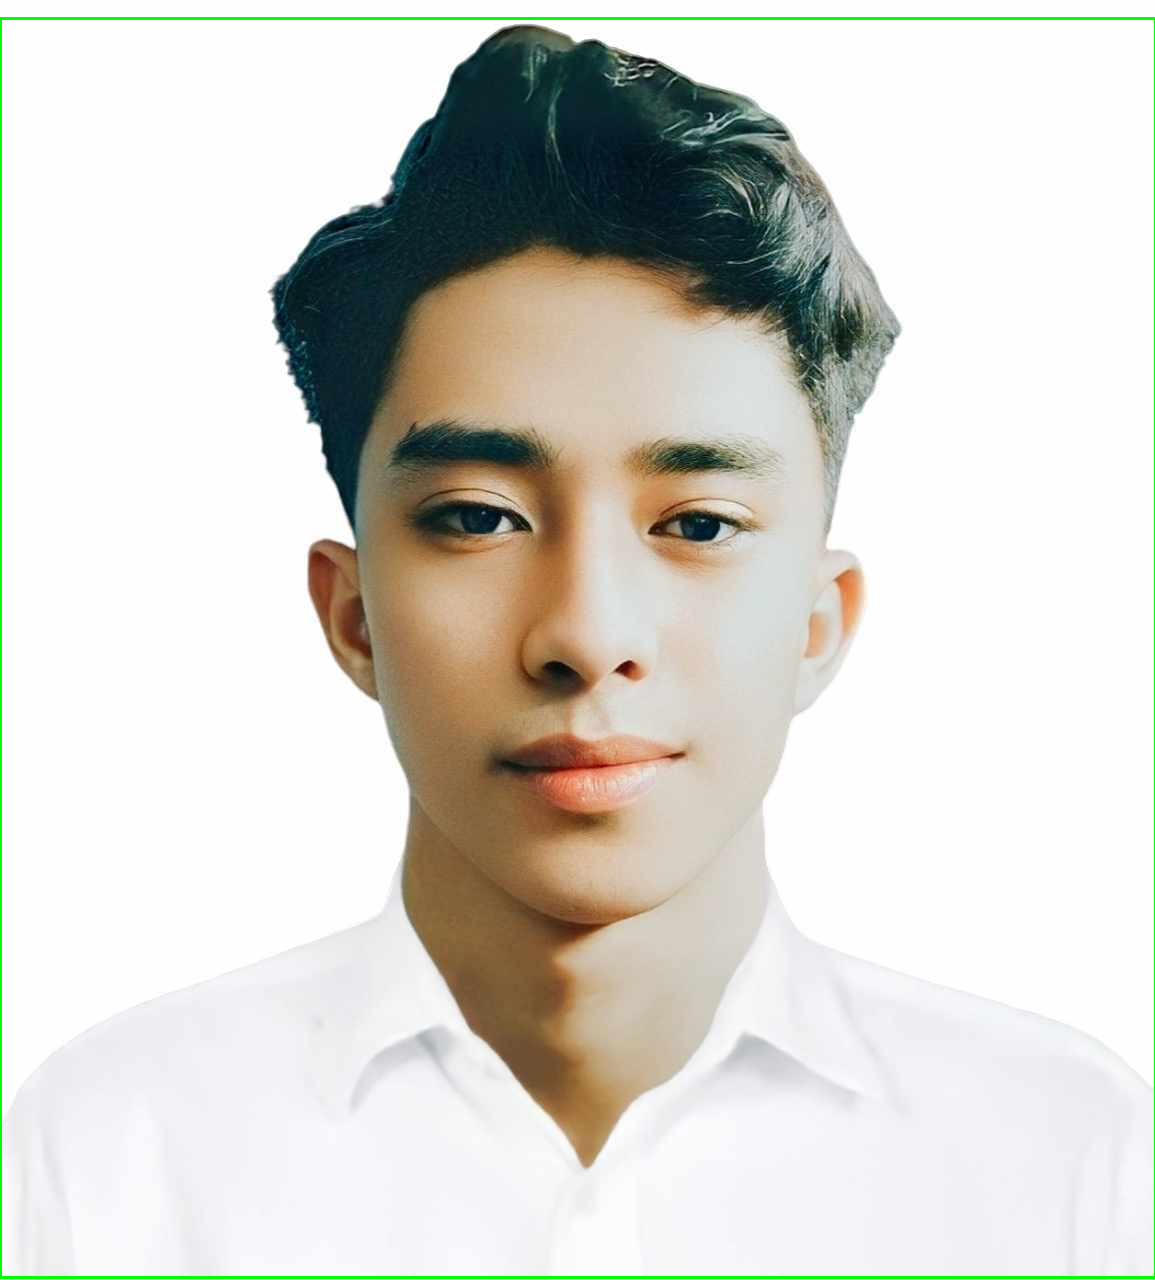

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Use this for image display in Colab

# Load the pre-trained SSD model from TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model = hub.load(model_url)

# Load and preprocess the image
image_path = 'original_image1.jpg'
image_np = cv2.imread(image_path)
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for TensorFlow
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# Run the model on the input image
detections = model(input_tensor)

# Extract detection results
num_detections = int(detections['num_detections'])
detection_boxes = detections['detection_boxes'][0].numpy()
detection_scores = detections['detection_scores'][0].numpy()
detection_classes = detections['detection_classes'][0].numpy()

# Visualize the bounding boxes for detections with confidence > 0.5
for i in range(num_detections):
    if detection_scores[i] > 0.5:
        # Get bounding box coordinates
        ymin, xmin, ymax, xmax = detection_boxes[i]
        (left, right, top, bottom) = (xmin * image_np.shape[1], xmax * image_np.shape[1],
                                      ymin * image_np.shape[0], ymax * image_np.shape[0])

        # Draw the bounding box
        cv2.rectangle(image_np, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)

# Convert image back to BGR for display
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Display the image using cv2_imshow
cv2_imshow(image_np)


#***Exercise 4: Traditional vs. Deep Learning Object Detection Comparison***

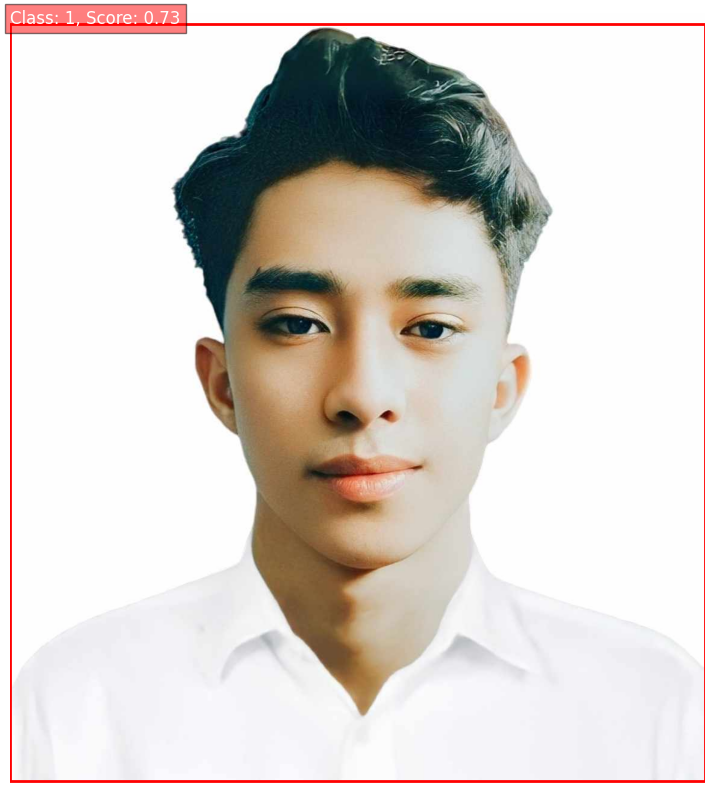

HOG-SVM Detection Time: 0.00 seconds
SSD/YOLO Detection Time: 0.07 seconds


In [10]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle

# Step 1: Load and preprocess the image
image_path = 'original_image1.jpg'  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

# Function to preprocess the image for SSD/YOLO models
def preprocess_image(image, target_size=(300, 300)):
    """Resize the image for SSD or YOLO model and ensure it is of type uint8."""
    image_resized = cv2.resize(image, target_size)
    image_resized = image_resized.astype(np.uint8)  # Ensure type is uint8
    image_expanded = np.expand_dims(image_resized, axis=0)  # Adding batch dimension
    return image_expanded

# Load the SSD model (update with the correct path if needed)
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
ssd_model = hub.load(model_url)

# Preprocess the image and perform detection
input_image = preprocess_image(image_rgb)
infer = ssd_model.signatures['serving_default']
outputs = infer(tf.convert_to_tensor(input_image))

# Extract bounding boxes, scores, and class labels for SSD
boxes = outputs['detection_boxes'].numpy()[0]
scores = outputs['detection_scores'].numpy()[0]
classes = outputs['detection_classes'].numpy()[0]

# Step 2: Plot the image and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
ax = plt.gca()

# Threshold to only show bounding boxes for objects with a high score
threshold = 0.5

# Get the image dimensions to map the bounding boxes to the original image size
image_height, image_width, _ = image_rgb.shape

for i in range(len(scores)):
    if scores[i] >= threshold:
        # Convert the normalized box coordinates to pixel coordinates
        ymin, xmin, ymax, xmax = boxes[i]
        xmin = int(xmin * image_width)
        xmax = int(xmax * image_width)
        ymin = int(ymin * image_height)
        ymax = int(ymax * image_height)

        # Draw a rectangle on the image
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add the class label and score
        label = f"Class: {int(classes[i])}, Score: {scores[i]:.2f}"
        plt.text(xmin, ymin, label, color='white', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

start_time = time.time()
# Predict using SVM (Assuming you've trained the model)
# predictions = svm.predict(hog_features)
end_time = time.time()
hog_svm_time = end_time - start_time

# Measure time for SSD/YOLO
start_time = time.time()
outputs = infer(tf.convert_to_tensor(input_image))  # SSD/YOLO detection
end_time = time.time()
ssd_yolo_time = end_time - start_time

# Example comparison output
print(f"HOG-SVM Detection Time: {hog_svm_time:.2f} seconds")
print(f"SSD/YOLO Detection Time: {ssd_yolo_time:.2f} seconds")